# Gender Pay Gap: Predicting income based on demographic data

## Abstract
What are the biggest indicators of a person's income? Their education level? Race? Gender? Age? What are demographic indicators that improve a woman's pay versus a man's?

For this project... 

## Introduction
As a teacher of underserved populations, I routinely tell my students that education is their greatest source of upward mobility.  I know that their race and, for the females, their gender currently work against them.  My biggest question is which of these factors are most important in increasing a person's income, and just how wide is the income gap for women, minorities, and those with lower levels of education?  A person cannot change most of these indicators, as those are the cards they are dealt in life, but of the ones they can change, how much of an impact does this have on income?

The data I will be using is extacted from the [1994 census bureau database](http://www.census.gov/ftp/pub/DES/www/welcome.html).  This dataset contains census data from approximately 32,000 working people over the age of 16, who made over 100 dollars that year, and who are representative of the larger population.  For each of these people, the dataset tracks a person's age, native country, marital status, education, employment, capital gains and losses as well as the target variable, whether or not the person's income was over $50,000 for that year.

### Research Questions
I will be attempting to answer the following questions:
- What demographic data is the best determinant for a person's income to be over \$50,000?
- Do those features differ between men and women?
- Do these features differe between white and non-white people?

### Models
To answer these questions, I will be using random forests, support vector machine classifier models, and logistic regression models.

## Imports

In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='white', color_codes=True)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Cross calidation and statistics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

## Uploading, Cleaning, and Describing Data

In [2]:
inc_raw = pd.read_csv('adult.data.csv', header=None, names=['age','workclass','fnlwgt','education',
                                                            'education_num','marital_status','occupation',
                                                            'relationship','race','sex','capital_gain',
                                                            'capital_loss','hours_per_week','native_country','income'])
inc_raw.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
inc_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Based on this information, none of the columns have null values, and while 6 of the column entries are integer values, 9 of the column entries are categorical in nature.  Now, I will inspect the number of unique entries for each column to get a better sense of the data.

In [4]:
inc_raw.nunique()

age                  73
workclass             9
fnlwgt            21648
education            16
education_num        16
marital_status        7
occupation           15
relationship          6
race                  5
sex                   2
capital_gain        119
capital_loss         92
hours_per_week       94
native_country       42
income                2
dtype: int64

Some initial observations I had while inspecting the number of unique entries:
- The final weight column has the most unique values.  This column represents the number of people that an entry could represent.  This makes sense as to why this number is so large, because there is a large spread in the number of people who are similar to an entry.  In my analysis, I am not trying to model proportions of the population or total values for the population, I will drop this column from the data set.
- The education and education number columns both have 16 unique values.  This is because the level of education is represented numerically by the education number column.  I will inspect this further, but will only use one column in my analysis.
- There are 7 different marital status types, but 6 relationshp status types.  This is worth looking further into. 
- Capital gains and capital losses have a limited number of unique entries.  I would have expected more.  This tells me that there aren't many people who reported capital gains or losses this year. 
- A person's native country has 42 possible entries.  If I want to analyze this data based on immigrant status or race, I will likely need to make this category more broad. 

Now, let's inspect the different values in each of the columns to get a better sense of what each column is describing and clean the data where necessary.

In [5]:
inc_raw.workclass.value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

This data set is very skewed in favor of employees of the private sector.  This makes sense because most of the work force is a part of the private sector.  There are also a good number of people employed by various governmnent entities, self-employed, and a small number either without pay or never worked.  I will combine those into three groups, government, self-employed, and not working.  There is about 5% of the data that has unknown working class. I will drop these entries because it is impossible to impute the data or take the mean of the type of work, and these make up such a small portion of the data.

In [6]:
#creating new data frame with updated working class categories
inc = inc_raw[inc_raw['workclass'] != '?']
inc.workclass.value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

__I'm having trouble manipulating the data set at all.  Above I can't filter out the unknown working class and (not shown) I can't rename the values.  I've tried code similar to what I've used before and it isn't working, and I've tried code from this same data set that isn't working.  Thoughts?__

__I'm going to write some EDA that I want to run when this is working...__

## Exploratory Data Analysis

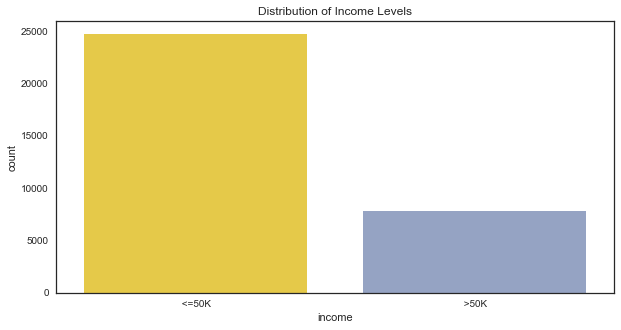

Percent of Low Income:  100.0


In [7]:
plt.figure(figsize=(10,5))
sns.countplot(x='income', data=inc_raw, palette='Set2_r')
plt.title('Distribution of Income Levels')
plt.show()

print('Percent of Low Income: ', len(inc_raw.income == ' >50K')/len(inc_raw)*100)

__Why are the calculations not working too?!? I'm having trouble selecting from a data set!?!__

There are more people that earn over \$50,000 per year, than people who don't. This is great news for the American people, and this also means that I have a class imbalance

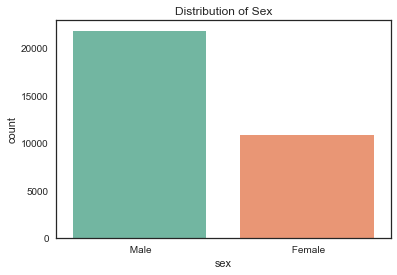

Percent of Male:  100.0


In [8]:
sns.countplot(x='sex', data=inc_raw, palette='Set2')
plt.title('Distribution of Sex')
plt.show()

print('Percent of Male: ', len(inc_raw.sex == ' Male')/len(inc_raw)*100)

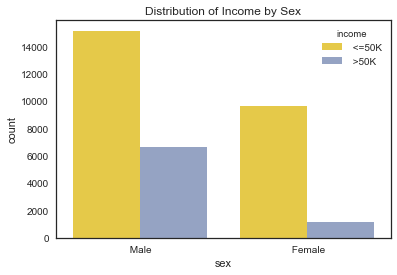

In [9]:
sns.countplot(x='sex', data=inc_raw, hue='income', palette='Set2_r')
plt.title('Distribution of Income by Sex')
plt.show()

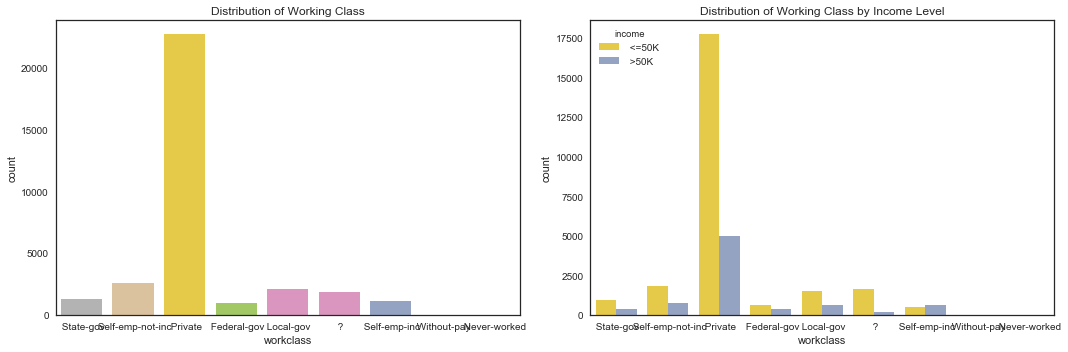

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(x='workclass', data=inc_raw, palette='Set2_r')
plt.title('Distribution of Working Class')

plt.subplot(122)
sns.countplot(x='workclass', hue='income', data=inc_raw, palette='Set2_r')
plt.title('Distribution of Working Class by Income Level')

plt.tight_layout()
plt.show()

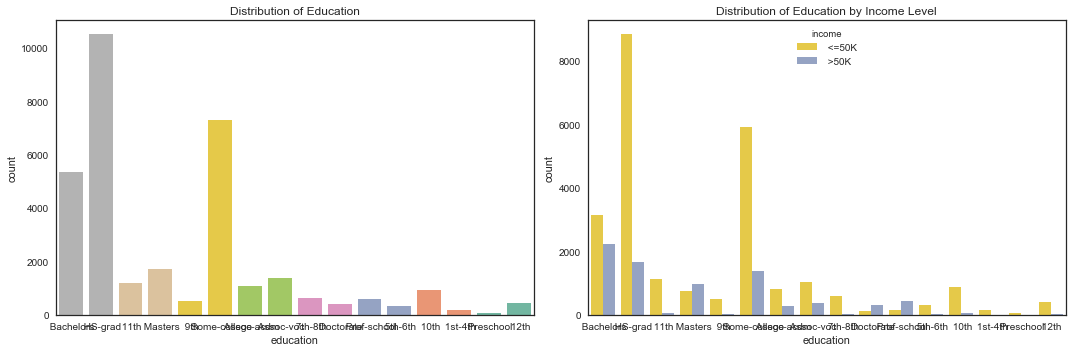

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(x='education', data=inc_raw, palette='Set2_r')
plt.title('Distribution of Education')

plt.subplot(122)
sns.countplot(x='education', hue='income', data=inc_raw, palette='Set2_r')
plt.title('Distribution of Education by Income Level')

plt.tight_layout()
plt.show()